In [1]:
#import relevant libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import auto_arima

In [2]:
#read in data
df = pd.read_csv('teleco_time_series .csv')

In [3]:
#check df shape
df.shape

(731, 2)

In [4]:
#check first 10 rows of data
df.head(10)

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
5,6,0.107654
6,7,0.493901
7,8,0.376698
8,9,0.304075
9,10,0.591748


In [47]:
#Check for null values
df.isnull().any()

Revenue    False
dtype: bool

In [5]:
#drop first row as it is a 0
df = df.drop(labels=0, axis=0)
df.head()

,Day,Revenue
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
5,6,0.107654


In [6]:
#convert day to date
df['Date'] = (pd.date_range(start=datetime(2020, 1, 2),
                           periods=df.shape[0], freq='24H'))
df.set_index('Date', inplace=True)
df

,Day,Revenue
Date,,
2020-01-02,2,0.000793
2020-01-03,3,0.825542
2020-01-04,4,0.320332
2020-01-05,5,1.082554
2020-01-06,6,0.107654
...,...,...
2021-12-27,727,16.931559
2021-12-28,728,17.490666
2021-12-29,729,16.803638


In [ ]:
df.drop('Day', axis=1, inplace=True)
df

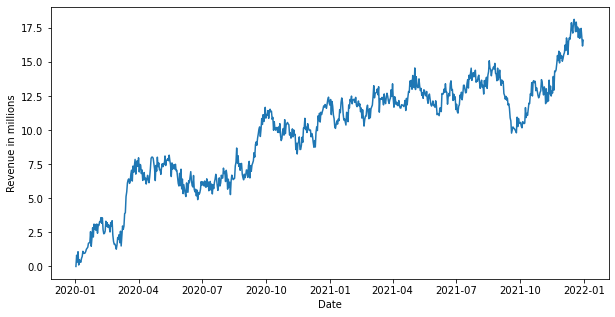

In [46]:
#visualize the data
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Revenue in millions')
plt.plot(df)

In [9]:
#Now use ADF test to determine if the series is stationary
result = adfuller(df['Revenue'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

ADF Statistic: -1.7746383121968694
p-value: 0.3931237595029741
Critical Values:
	1%: -3.4393644334758475
	5%: -2.8655182850048306
	10%: -2.568888486973192
Fail to reject null hypothesis, the time series is non-stationary


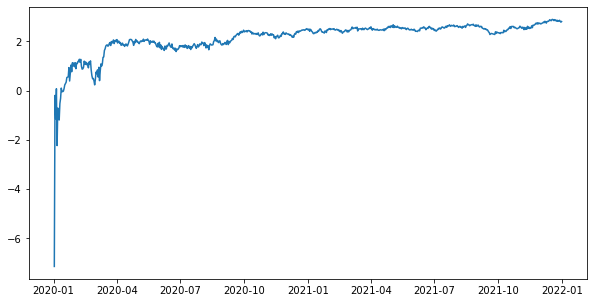

In [10]:
df_log = np.log(df)
plt.figure(figsize=(10,5))
plt.plot(df_log)
plt.show()

In [11]:
#create function to use to determine stationarity
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

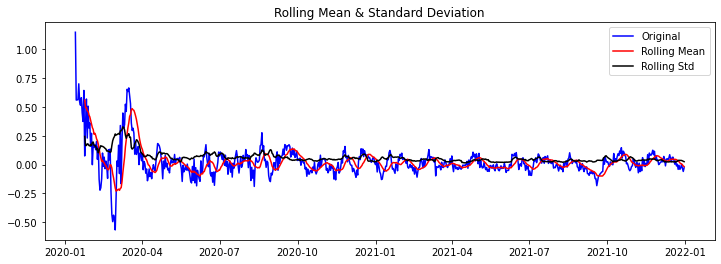

ADF Statistic: -6.477012043202165
p-value: 1.3234438629630354e-08
Critical Values:
	1%: -3.439633170421852
	5%: -2.8656367026715337
	10%: -2.5689515744354794


In [43]:
#subtract the rolling mean to get stationarity
plt.figure(figsize=(12,4))
rolling_mean = df_log.rolling(window=12).mean()
df_stationary = df_log - rolling_mean
df_stationary.dropna(inplace=True)

get_stationarity(df_stationary)

In [42]:
df_stationary.to_csv(r'C:\Users\Masey\Documents\School Work\D213\Cleaneddatatask1.csv')

In [13]:
#p-value is less than .05, so data is stationary

#split the dataset
X_train = df.loc[:'2021-09-30']
X_test = df['2021-10-01':]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (638, 1)
X_test Shape (92, 1)


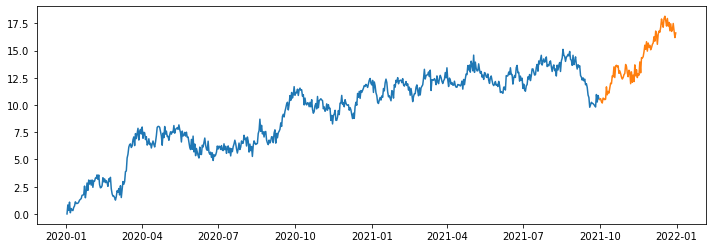

In [44]:
plt.figure(figsize=(12,4))
plt.plot(X_train)
plt.plot(X_test)

<AxesSubplot:xlabel='Date'>

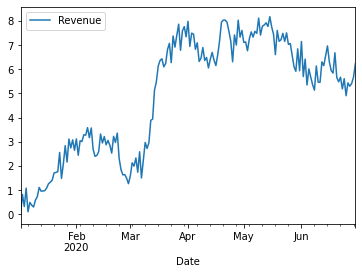

In [15]:
#check for seasonality of the data by looking at a subset

df.loc[:'2020-06-30'].plot()

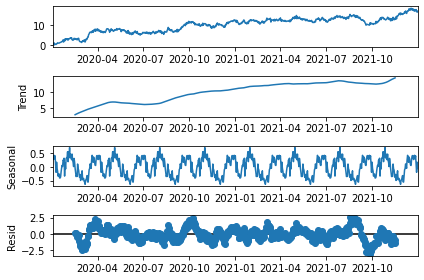

In [16]:
#We can see that there is some seasonality in the data

#Peform decomposition
decom = seasonal_decompose(df, period=90)

#plot decomposition
decom.plot()
plt.show()

<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

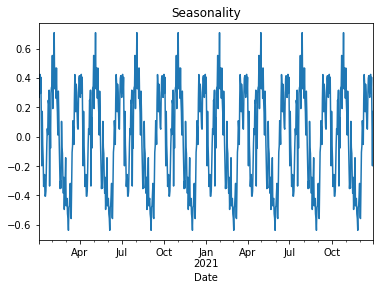

In [17]:
#plot seasonality

plt.title('Seasonality')
decom.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}, xlabel='Date'>

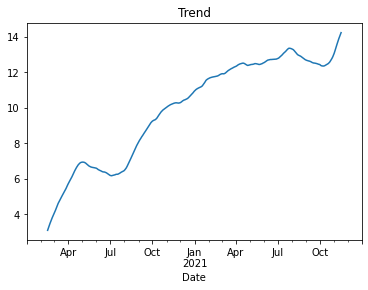

In [18]:
#plot trend

plt.title('Trend')
decom.trend.plot()

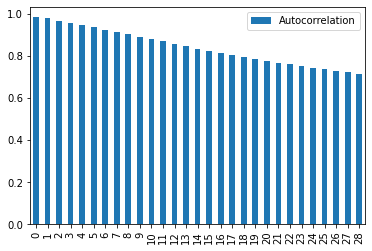

In [50]:
#Autocorrelation plots
acf_1 = acf(X_train)[1:30]
ac_df = pd.DataFrame([acf_1]).T
ac_df.columns = ['Autocorrelation']
ac_df.plot(kind='bar')
plt.show()

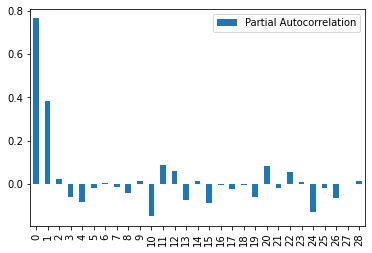

In [49]:
pacf_1 = pacf(df_stationary)[1:30]
pac_df = pd.DataFrame([pacf_1]).T
pac_df.columns = ['Partial Autocorrelation']
pac_df.plot(kind='bar')
plt.show()

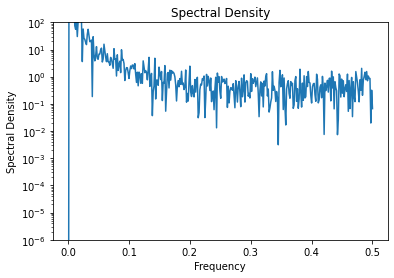

In [21]:
#spectral density

f, Pxx_den = signal.periodogram(df['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>

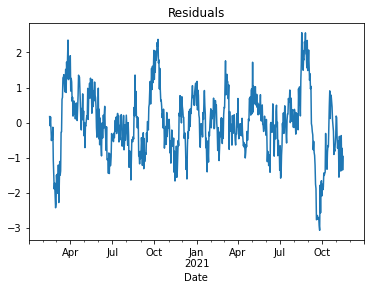

In [22]:
#plot residual
plt.title('Residuals')
decom.resid.plot()

In [23]:
#Auto Arima

#find the best model using auto_arima (includes seasonality)
model = auto_arima(X_train,
                      seasonal=True, m=12,
                      d=1, D=1,
                      start_p=1, start_q=1,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      supress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1416.491, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1092.763, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1281.890, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=983.879, Time=1.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.55 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1141.358, Time=0.76 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=985.753, Time=1.75 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=985.787, Time=2.05 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1020.170, Time=1.39 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=985.340, Time=3.52 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=985.579, Time=3.41 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]       

In [33]:
#Ftting the Time Series Model
ts_model = SARIMAX(df, order=(1,1,0), seasonal_order=(2,1,0,12))
results = ts_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -571.857
Date:                            Sun, 17 Jul 2022   AIC                           1151.714
Time:                                    00:08:37   BIC                           1170.014
Sample:                                01-02-2020   HQIC                          1158.780
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4961      0.033    -15.261      0.000      -0.560      -0.432
ar.S.L12      -0.7043      0.037    -18.952      0.000      -0.777      -0.631
ar.S.L24      -0.3916      0.038    -10.436      0.000      -0.465      -0.318
sigma2         0.2855      0.016     18.095      0.000       0.255       0.316
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.85   Prob(JB):                         0.63
Heteroskedasticity (H):               1.07   Skew:                            -0.02
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
#print mean absolute error
mae = np.mean(np.abs(results.resid))
print("Mean absolute error", mae)

Mean absolute error 0.428113134584656


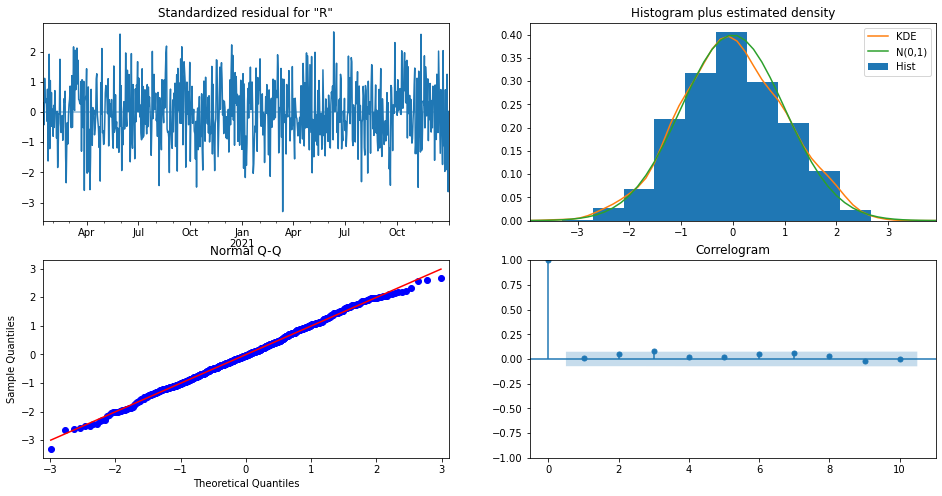

In [35]:
#create the 4 diagnostics plots
results.plot_diagnostics(figsize=(16, 8)).show()

In [36]:
#perform forecast

#forecast
diff_forecast=results.get_forecast(steps=180)
mean_forecast=diff_forecast.predicted_mean

print(mean_forecast.head())

#get confidence intervals of prediction
confidence_intervals=diff_forecast.conf_int()

#select lower and upper confidence limits
lower_limits=confidence_intervals.loc[:, 'lower Revenue']
upper_limits=confidence_intervals.loc[:, 'upper Revenue']

2022-01-01    16.434303
2022-01-02    16.129556
2022-01-03    16.459170
2022-01-04    16.521516
2022-01-05    16.315253
Freq: D, Name: predicted_mean, dtype: float64


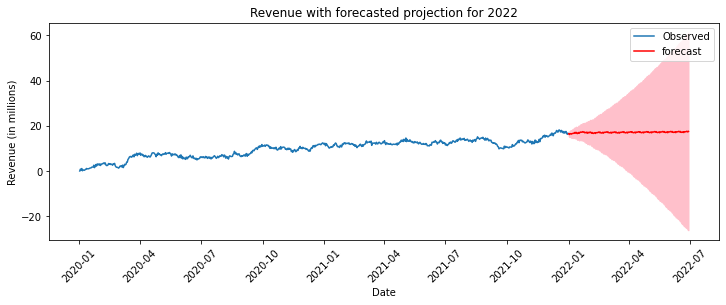

In [45]:
#plot the forecasted revenue data
plt.figure(figsize=(12,4))
plt.plot(df.index, df, label='Observed')
#plot the mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label = 'forecast')

#shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

#set labels, legends and show plot
plt.title('Revenue with forecasted projection for 2022')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Revenue (in millions)'>

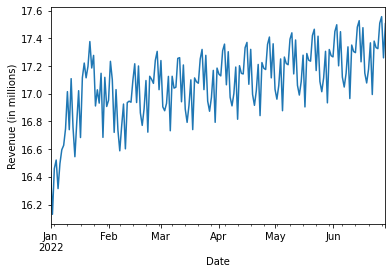

In [38]:
#plt.title('Revenue projection for year 2022')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
mean_forecast.plot()

In [39]:
#Validate with test set

#generate predictions

prediction = results.get_prediction(start=-90)

#Extract prediction mean
mean_prediction = prediction.predicted_mean

#get confidence intervals of prediction
confidence_intervals1 = prediction.conf_int()

#Select lower and upper confidence limits
lower_limits1 =confidence_intervals1.loc[:, 'lower Revenue']
upper_limits1 =confidence_intervals1.loc[:, 'upper Revenue']

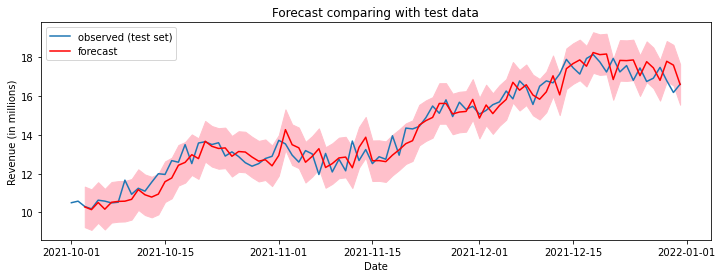

In [40]:
#plot the data
plt.figure(figsize=(12,4))
plt.plot(X_test.index, X_test, label='observed (test set)')

#plot your mean prediction
plt.plot(mean_prediction.index, mean_prediction, color='r', label = 'forecast')

#shade the area between your confidence limits
plt.fill_between(lower_limits1.index, lower_limits1, upper_limits1, color='pink')

#set labels, legends and show plot
plt.title('Forecast comparing with test data')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.legend()
plt.show()